# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project Notebook: Structured Data Classification

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Problem Statement

To predict whether a patient has a heart disease.

## Learning Objectives

At the end of the experiment, you will be able to

* Understand the Cleveland Clinic Foundation for Heart Disease dataset.
* Pre-process this dataset using Keras layers: IntegerLookup, StringLookup & Normalization
* Understand and use Keras concatenate layer
* Build a neural network  architecture and model using Keras functional api.
* Predict an unseen data.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

### Dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Import Required Packages

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup     # Used in Feature processing
from tensorflow.keras.layers import Normalization     # Used in Feature processing
from tensorflow.keras.layers import StringLookup      # Used in Feature processing

# Part A

## Load the data and create batches [2 Marks]

### Load data into a Pandas dataframe

Hint:: pd.read_csv

In [ ]:
file_url = "/content/heart.csv"
dataframe = pd.read_csv(file_url)

Check the shape of the dataset:

In [ ]:
dataframe.shape

(303, 14)

Check the preview of a few samples:

Hint:: head()

In [ ]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Draw some inference from the data. What does the target column indicate?

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

### Split the data into a training and validation set

Hint:: Use .sample() method from Pandas.

Refer to link [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)

Official reference from pandas for drop method [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


### Converting into tensorflow dataset & creating batches

Generate `tf.data.Dataset` objects for each dataframe:

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create the tuple using tensorflow.

In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
# Visualizing one datapoint from the formatted data
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=53>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=138>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=234>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


#### Create the batch of the datasets:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to create a batch using tensorflow.

In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers [3 Marks]

### Categorical Features Encoding

The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will throw an error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and **reserve
 an output index for unkown input values**.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Create a function `encode_categorical_feature`, this function takes four parameters.
1. Feature to be encoded.
2. Name of the feature in the dataset.
3. Dataset containing the feature.
4. A boolean value wether the feature is string or not.

**Refer :** StringLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) and IntegerLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup).

In [ ]:
def encode_categorical_feature(feature, name, dataset, is_string):

    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # 'one_hot' or binary

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Numerical features Normalization
The following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.


- Define a function `encode_numerical_feature` to apply featurewise normalization to numerical features.


Refer Normalization [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [ ]:
def encode_numerical_feature(feature, name, dataset):

    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


# Part B

## Building the model [4 Marks]

#### Need to instantiate a Keras tensor for all features
 Use keras Input() [method](https://keras.io/api/layers/core_layers/input/).
* Create a list of inputs to be fed to the model.
* This list consists of the features output from keras Input() method.
* These inputs include all the features.


In [ ]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [sex, cp, fbs, restecg,exang,ca,thal,age,trestbps,chol,thalach,oldpeak,slope]
## These list of inputs objects are fed inside the model as inputs

### Encoding above features
Use  "encode_categorical_feature" & "encode_numerical_feature" function on respective features that we defined above.

In [ ]:
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

##### Understanding the result of  encoder functions

In [ ]:
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
sex_encoded

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'integer_lookup_6')>

In [ ]:
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
cp_encoded

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_7')>

### Using Functional API for building model
* These inputs will be passed to keras.model.
* Concatenate the encoded features using [layers.concatenate()](https://keras.io/api/layers/merging_layers/concatenate/)
* Add the Dense layers and compile the model.

In [ ]:
all_inputs = [sex, cp, fbs, restecg,exang,ca,thal,age,trestbps,chol,thalach,oldpeak,slope]

all_features = layers.concatenate([sex_encoded,cp_encoded,fbs_encoded,restecg_encoded,exang_encoded,slope_encoded,
                                   ca_encoded,thal_encoded,age_encoded,trestbps_encoded,chol_encoded,thalach_encoded,oldpeak_encoded])

## In Functional API for creating a Neural Network model.
## Different layers are connected as layers.method(previous layer object)
## For eg: x = layers.Dense(32, activation="relu")(all_features), similarly
## layers.concatenate is connected to Input or Initialization of keras tensors.
## layers.concatenate([encoded_feature_object1, encoded_feature_object2, .....]), where
## encoded_feature_objects contains the return values from encode_categorical and encode_numerical features.

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 restecg (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

### Visualize the connectivity graph using `keras.utils.plot_model`:

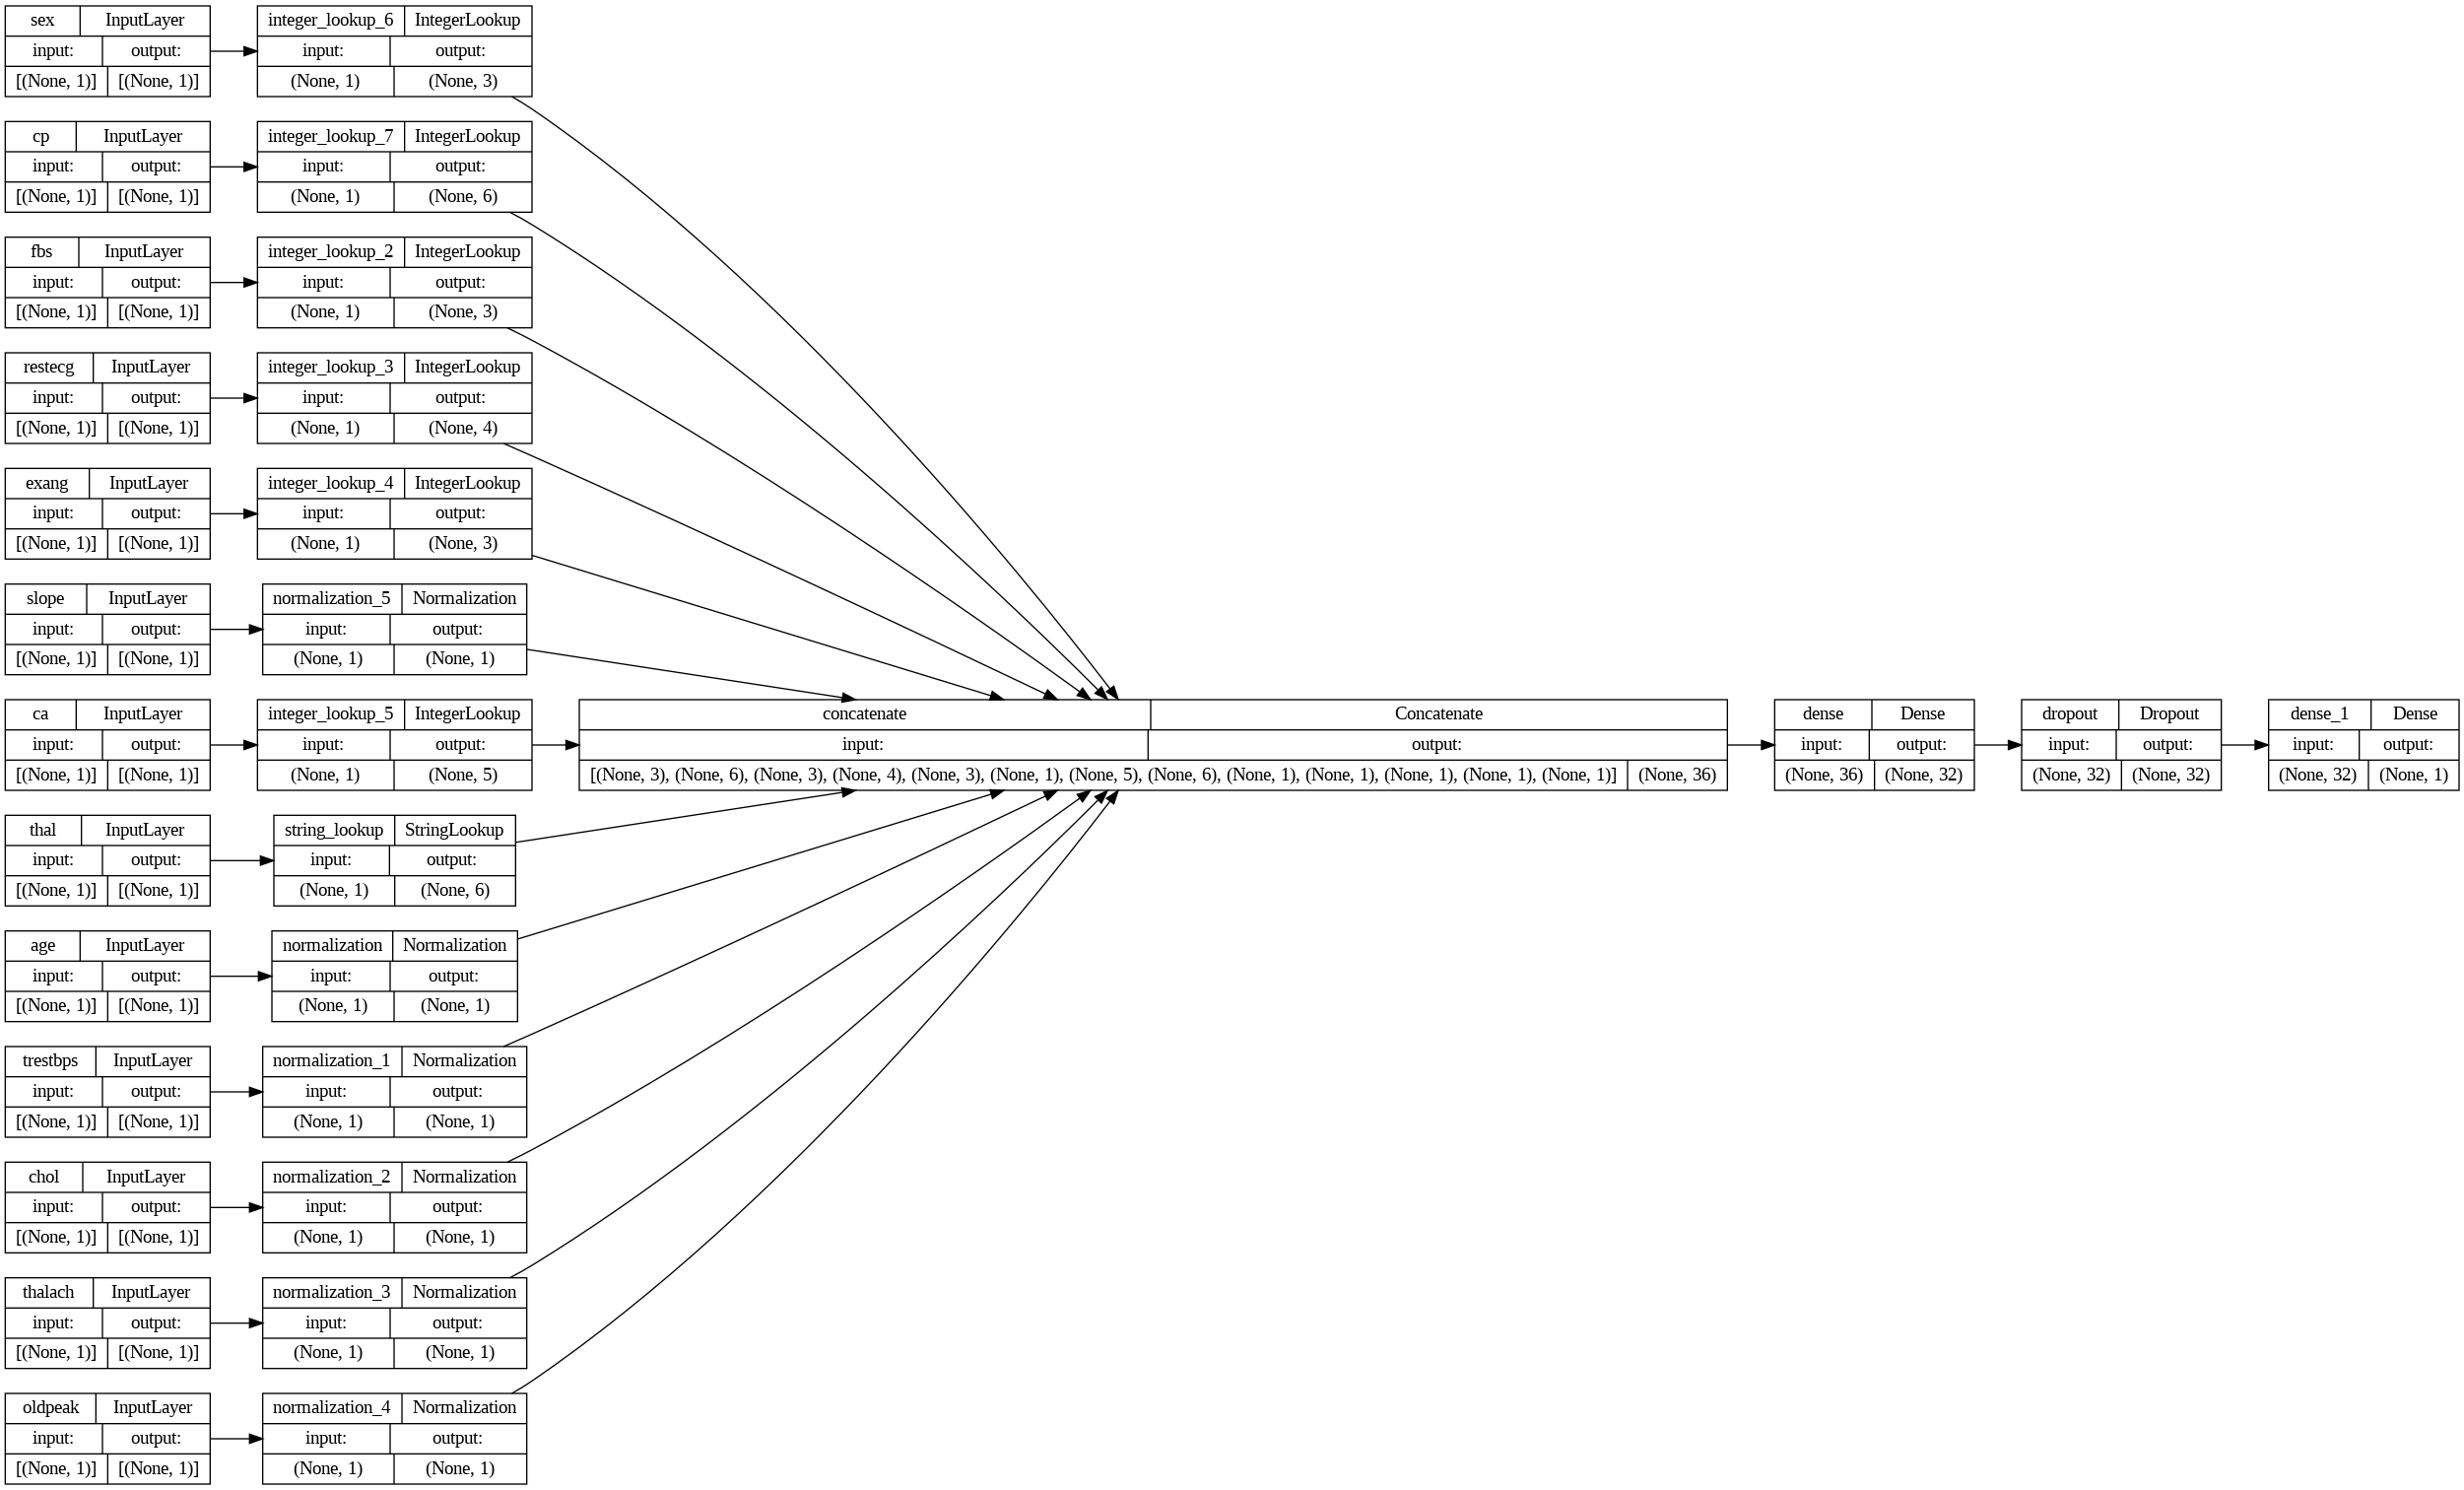

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the model

In [ ]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 11s 123ms/step - loss: 0.7238 - accuracy: 0.5661 - val_loss: 0.6724 - val_accuracy: 0.6066
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.7050 - accuracy: 0.5579 - val_loss: 0.6278 - val_accuracy: 0.7049
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6423 - accuracy: 0.6198 - val_loss: 0.5889 - val_accuracy: 0.7377
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.6302 - accuracy: 0.6777 - val_loss: 0.5588 - val_accuracy: 0.7541
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.5948 - accuracy: 0.6612 - val_loss: 0.5344 - val_accuracy: 0.7869
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.5201 - accuracy: 0.7397 - val_loss: 0.5136 - val_accuracy: 0.7541
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.5019 - accuracy: 0.7893 - val_loss: 0.4955 - val_accuracy: 0.7705
Epoch 8/50
8/8 [=========

We quickly get to 80% validation accuracy.

## Inference on new data [1 Mark]

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [ ]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 389ms/step
This particular patient had a 24.3 percent probability of having a heart disease, as evaluated by our model.
